# Financial Analysis: What Debt is Worth the Bank's Effort
# Daniel Weatherspoon

## Background
This project revolves around banks dealing with debt that is legally declared uncollectable. A bank will not walk away from a debt without collecting anything, they will still try to get something from the debt. This projects purpose is to build my knowledge and background in the financial field. I will be recreating a situation where a bank has given bad customers different recovery strategies, and this is based on the expected amount the bank believes it will recover from the customer. As the data scientist here, I will determine whether the amount the bank earns exceeded the cost of assigning customers recovery strategies.

The bank implemented recovery strategies at different thresholds ($1000, $2000, $3000, and $5000), the greater the ERA or Expected Recovery Amount, the more effort the bank has put into contacting the customer.

- Level 0: ERA = $0 - <=$1000
- Level 1: ERA = >$1000 - <=$2000


## Imports

In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats
import statsmodels.api as sm
import seaborn as sns

## Exploratory Data Analysis

In [8]:
df = pd.read_csv('bank_data.csv')
# rename columns to call easier
df = df.rename(columns={'expected_recovery_amount': 'ExpectedRA', 'actual_recovery_amount': 'ActualRA'})
df.head(10)

,id,ExpectedRA,ActualRA,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male
5,731,548,520.710,Level 0 Recovery,35,Male
6,221,549,221.585,Level 0 Recovery,33,Male
7,1932,560,373.720,Level 0 Recovery,19,Female
8,1828,562,201.865,Level 0 Recovery,22,Female
9,2001,565,504.885,Level 0 Recovery,27,Male


In [32]:
df.describe()

,id,ExpectedRA,ActualRA,age,indicator_1000
count,1882.000000,1882.000000,1882.000000,1882.000000,1882.000000
mean,1035.596174,2759.967588,4000.967837,39.650372,0.869288
std,591.458429,2019.826565,4576.506350,15.453072,0.337175
min,6.000000,194.000000,200.425000,18.000000,0.000000
25%,534.250000,1261.250000,1045.190300,28.000000,1.000000
50%,1029.500000,2062.000000,2115.446373,35.000000,1.000000
75%,1551.750000,3569.500000,5417.237207,50.000000,1.000000
max,2056.000000,9964.000000,34398.479710,84.000000,1.000000


array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'ExpectedRA'}>],
       [<Axes: title={'center': 'ActualRA'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'indicator_1000'}>, <Axes: >]],
      dtype=object)

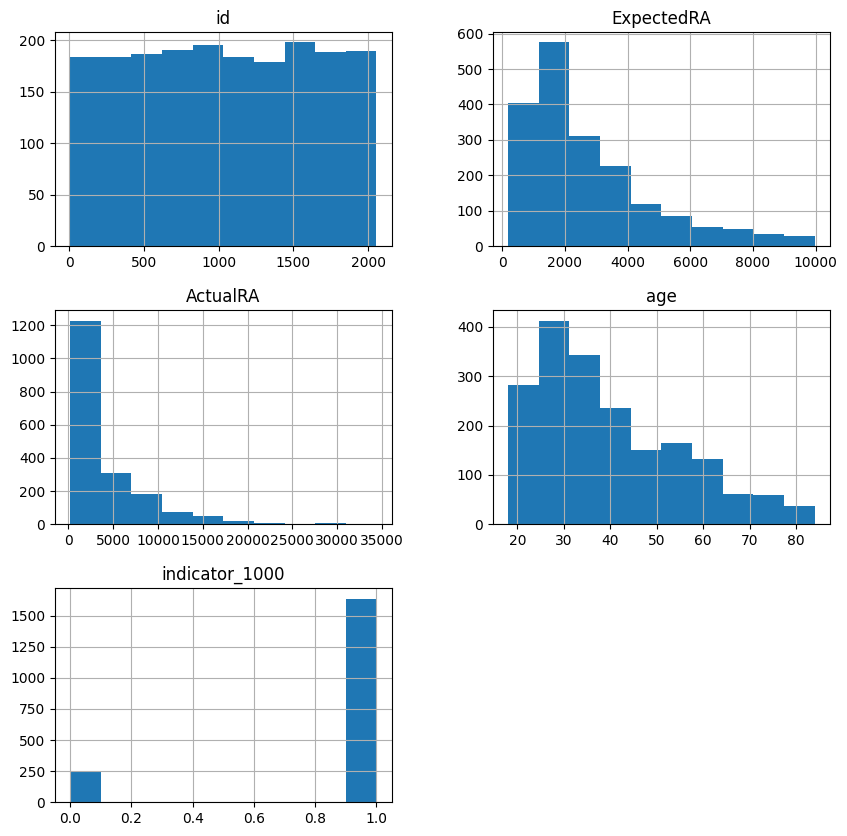

In [33]:
df.hist(figsize=(10,10))

Are there other factors besides ERA? Does age show discontinuity? Does sex make a difference?

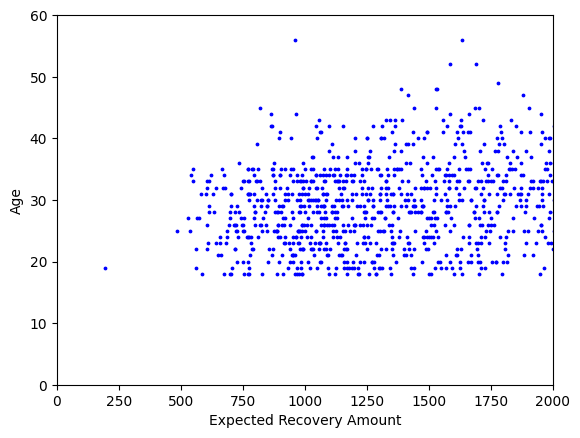

In [10]:
plt.scatter(df['ExpectedRA'], df['age'], c = 'blue', s = 3)
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Age')
plt.xlim(0,2000)
plt.ylim(0,60)
#For the window of $0 to $2000 only
plt.show()
# No significant jump / discontinuity in the scatter plot

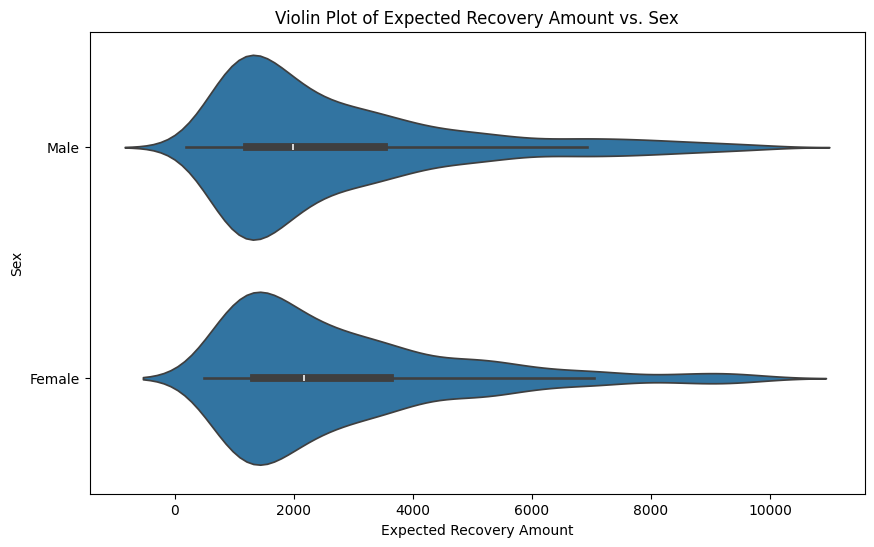

In [24]:
plt.figure(figsize=(10, 6))
sns.violinplot(y = df['sex'], x = df['ExpectedRA'])
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Sex')
plt.title('Violin Plot of Expected Recovery Amount vs. Sex')
plt.show()
#No significant difference in Expected Recovery Amount between sexes

### Statistical Test - Age vs. ERA
To be able to conclude that differences in ActualRA and ExpectedRA are not due to sex and age, I'll do statistical analysis to see the average age of customers from slightly below and slightly above the threshold. For this I'll use the Kruskal-Wallis test, it makes no distributional assumptions.

In [25]:
era_900_1100 = df.loc[(df['ExpectedRA'] < 1100) & (df['ExpectedRA'] >= 900)]

by_recovery_strategy = era_900_1100.groupby('recovery_strategy')
by_recovery_strategy['age'].describe().unstack()

#Kruskal-Wallis Test
level_0_age = era_900_1100.loc[df['recovery_strategy'] == "Level 0 Recovery"]['age']
level_1_age = era_900_1100.loc[df['recovery_strategy'] == "Level 1 Recovery"]['age']

stats.kruskal(level_0_age, level_1_age)

KruskalResult(statistic=3.4572342749517513, pvalue=0.06297556896097407)

The p-value is greater than 0.05, meaning we can reject the null hypothesis that the median is the same for all data.

### Statistical Test - Sex vs. ERA

In [26]:
# n customers in each category
crosstab = pd.crosstab(df.loc[(df['ExpectedRA'] < 1100) & (df['ExpectedRA'] >= 900)]['recovery_strategy'], df['sex'])
print(crosstab)

# Chi-Square Test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print("Chi-Square Statistic: {}, P-Value: {}".format(chi2_stat, p_val))

sex                Female  Male
recovery_strategy              
Level 0 Recovery       32    57
Level 1 Recovery       39    55
Chi-Square Statistic: 0.3796422112341753, P-Value: 0.5377947810444592


Chi-Square Stat is small so this means there is some sort of independence between the variables. On top of that, a P-Value larger than the Chi-Square Stat suggests that there isn't significant association between variables as well.

### Exploratory Graphical Analysis - Recovery Amount
I can see that customers just above and below the $1000 threshold are on average similar in their average age and the percentage that are male. Time to focus on the actual recovery amount now, an outcome of interest. Going to repeat some steps from above.

(0.0, 2000.0)

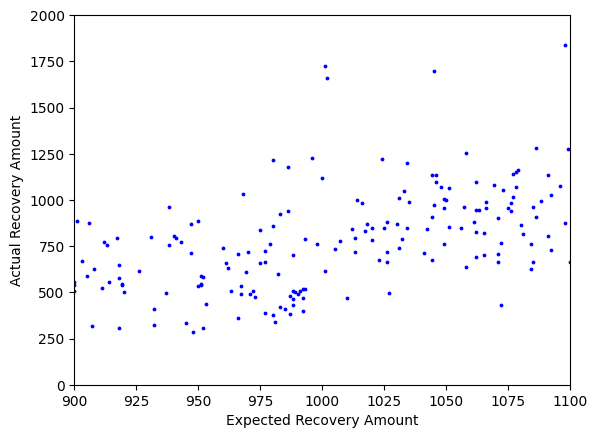

In [27]:
plt.scatter(x = df['ExpectedRA'], y = df['ActualRA'], c = 'blue', s = 3)
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')
plt.xlim(900, 1100)
plt.ylim(0, 2000)

In [28]:
# Average actual recovery amount just below and above threshold
by_recovery_strategy['ActualRA'].describe().unstack()

# Kruskal-Wallis Test
level_0_actual = era_900_1100.loc[df['recovery_strategy'] == "Level 0 Recovery"]['ActualRA']
level_1_actual = era_900_1100.loc[df['recovery_strategy'] == "Level 1 Recovery"]['ActualRA']

print(stats.kruskal(level_0_actual, level_1_actual))
print('------')

# Smaller range of $950 to $1050
era_950_1050 = df.loc[(df['ExpectedRA'] < 1050) & (df['ExpectedRA'] >= 950)]
level_0_actual = era_950_1050.loc[df['recovery_strategy'] == "Level 0 Recovery"]['ActualRA']
level_1_actual = era_950_1050.loc[df['recovery_strategy'] == "Level 1 Recovery"]['ActualRA']

stats.kruskal(level_0_actual, level_1_actual)

KruskalResult(statistic=65.37966302528878, pvalue=6.177308752803109e-16)
------


KruskalResult(statistic=30.246000000000038, pvalue=3.80575314300276e-08)

### Regression Modeling - No Threshold
Building two models, the first model has no threshold while the second will. First model will predict the actual recovery amount as a function of the expected recovery amount. There should be a very strong correlation.

Examining the adjusted R-squared to see the variance explained by model will help determine the success. 

In [29]:
#Defining the dependent and independent variables
X = era_900_1100['ExpectedRA']
y = era_900_1100['ActualRA']
X = sm.add_constant(X)

#Building model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

#Printing the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ActualRA   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     63.78
Date:                Sat, 27 Apr 2024   Prob (F-statistic):           1.56e-13
Time:                        15:31:32   Log-Likelihood:                -1278.9
No. Observations:                 183   AIC:                             2562.
Df Residuals:                     181   BIC:                             2568.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1978.7597    347.741     -5.690      0.000   -2664.907   -1292.612
ExpectedRA     2.7577      0.345      7.986      0.000       2.076       3.439
==============================================================================
Omnibus:                       64.493   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.818
Skew:                           1.463   Prob(JB):                     4.47e-41
Kurtosis:                       6.977   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Regression Modeling - Adding True Threshold
In the first model, I see that the expected recovery amount's regression coefficient is significant. 

This second model adds an indicator of the true threshold to the model, so at $1000 in this case. An indicator variable will be created (0 or 1) that represents whether or not the expected recovery amount was greater than $1000. When added to the true threshold of the model, the regression coefficient for the true threshold represents the additional amount recovered due to higher recovery strategy. 

If the higher recovery strategy helped recover more money, the regression coefficient of the true threshold will be greater than zero. If not, it won't be statistically significant.

In [30]:
#Creating indicator 
df['indicator_1000'] = np.where(df['ExpectedRA'] < 1000, 0, 1)
era_900_1100 = df.loc[(df['ExpectedRA'] < 1100) & (df['ExpectedRA'] >= 900)]

#Defining the dependent and independent variables
X = era_900_1100[['ExpectedRA', 'indicator_1000']]
y = era_900_1100['ActualRA']
X = sm.add_constant(X)

#Building model
model = sm.OLS(y, X).fit()

#Printing the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ActualRA   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     41.22
Date:                Sat, 27 Apr 2024   Prob (F-statistic):           1.83e-15
Time:                        15:41:54   Log-Likelihood:                -1272.0
No. Observations:                 183   AIC:                             2550.
Df Residuals:                     180   BIC:                             2560.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.3440    626.274      0.005      0.996   -1232.440    1239.128
ExpectedRA         0.6430      0.655      0.981      0.328      -0.650       1.936
indicator_1000   277.6344     74.043      3.750      0.000     131.530     423.739
==============================================================================
Omnibus:                       65.977   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.537
Skew:                           1.510   Prob(JB):                     3.12e-41
Kurtosis:                       6.917   Cond. No.                     3.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Regression Modeling - Adjustments
The regression coefficient for the true threshold was significant with an estimated impact close to $278. Much larger than the $50 needed to run this recovery strategy.

Just for good measure, I'll choose another window from $950 - $1050 to see if I get similar results.

In [31]:
#Redefine era_950_1050 so indicator variable is included
era_950_1050 = df.loc[(df['ExpectedRA'] < 1050) & (df['ExpectedRA'] >= 950)]

#Defining the dependent and independent variables
X = era_950_1050[['ExpectedRA', 'indicator_1000']]
y = era_950_1050['ActualRA']
X = sm.add_constant(X)

#Building model
model = sm.OLS(y, X).fit()

#Printing the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ActualRA   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     18.99
Date:                Sat, 27 Apr 2024   Prob (F-statistic):           1.12e-07
Time:                        15:54:35   Log-Likelihood:                -692.92
No. Observations:                  99   AIC:                             1392.
Df Residuals:                      96   BIC:                             1400.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -279.5243   1840.707     -0.152      0.880   -3933.298    3374.250
ExpectedRA         0.9189      1.886      0.487      0.627      -2.825       4.663
indicator_1000   286.5337    111.352      2.573      0.012      65.502     507.566
==============================================================================
Omnibus:                       39.302   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.258
Skew:                           1.564   Prob(JB):                     1.37e-18
Kurtosis:                       6.186   Cond. No.                     6.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Estimated impact is in a similar range!